## Este código se refere ao Projeto Final da disciplina de Imagens Biomédicas, disciplina oferecida pela UNIFESP.


Um Instituto renomado no Brasil faz todos os tipos de investigações,
intervenções, tratamentos e pesquisas relacionados ao coração. Dentre
eles, estão as investigações das coronárias, estas investigações são
realizadas com um equipamento chamado Ultrassom Intravascular (IVUS).
Este equipamento adquire imagens de seções transversais da coronária
pela inserção e movimento de retirada de um cateter (Figura). Contudo,
além de não fornecer informações objetivas, como dimensões, este
equipamento fornece centenas de imagens de uma mesma seção, o que
dificulta muito a análise por segmentação manual.
O pesquisador de cardiologia, quem usa este equipamento para
orientar doutorandos em medicina, pediu a criação de um aplicativo para
esta tarefa. O objetivo é fazer a segmentação e cálculo da área da borda
media-adventícia (parede externa do vaso) em imagens de IVUS.

- Elaborar um método automático ou semiautomático, que faça a
segmentação do lúmen em imagens de IVUS(Figura Abaixo em azul).
Divida o método em 3 partes, Pré-processamento, Extração de
Características e Pós-processamento.
- Avaliar este método de acordo com a metodologia de VP(%), FP(%),
FN(%). Adicionalmente, usar as métricas Overlap Dice(OD(%)) e
Overlap Ratio(OR(%)) descritas abaixo. Para a avaliação, usar 20
imagens de IVUS com seus respectivos GoldStandads. Img0.pgm até
img19.pgm com gsmab0.pgm até gsmab19.pgm.
- Resultados Projeto → A nota referente aos resultados do trabalho
será equivalente ao OR (%)

In [9]:
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

In [32]:
images_path = './imagens/'
images = list()

for dir, _, files in os.walk(images_path):
    for file in files:
        if 'img' in arquivo:
            images.append(
                {
                    'original': skimage.img_as_float(
                        cv2.imread(os.path.join(dir, file), 0)), 
                    'gold_standard': skimage.img_as_float(
                        cv2.imread(os.path.join(dir, file.replace('img', 'gsmab'))), 0),
                })

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

In [27]:
images

[{'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None},
 {'original': None, 'gold_standard': None}]

TypeError: Image data of dtype <U8 cannot be converted to float

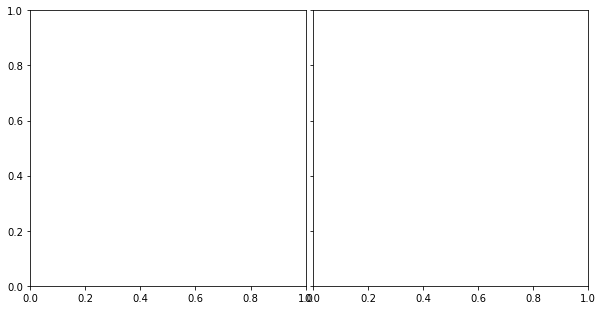

In [19]:
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

grid[0].imshow(images[0]['original'])
grid[1].imshow(images[0]['gold_standard'])